In [1]:
!pip install matplotlib
!pip install qutip
!pip install numpy 
!pip install scipy
!pip install Cython  

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_proj_ev as me

from IPython.display import display, Math, Latex

In [5]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(N, chain_type = "XXX", author=True, x=.5, gamma = 1*np.e*-2, 
                        omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = 1, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    
    Jx = .15; Jy = .25; Jz = .1; h = 1.

    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, True, 1, None, coeffs_me1_gr1, None, False)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-2 * np.full((a,b),1.)
        rho0 = me.initial_state(N, True, 2, None, coeffs_me2_gr2, None, False)
             
    elif(not gaussian):
        psi1_list = []
        psi1_list.append(qutip.basis(2,1))
        for n in range(N-1):
            psi1_list.append(qutip.basis(2,0))

        psi0 = qutip.tensor(psi1_list)
        rho0 = me.initial_state(N, False, None, x, None, psi0, False)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(2, N), rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(1, N))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
    
    x_op, p_op, comm_xp, corr_xp, p_dot = me.classical_ops("XXX", N, Jx, Jy, Jz, h)
    
    obs = [x_op, p_op, comm_xp, corr_xp, p_dot]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N, gamma, True)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=me.Heisenberg_Hamiltonian(chain_type, N, False, Jx, Jy, Jz, h), 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
sampling: 30


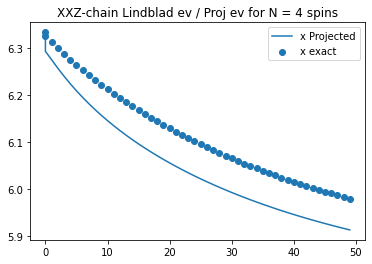

In [6]:
results = projected_evolution(4, "XXZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(4, "XXZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.title("XXZ-chain Lindblad ev / Proj ev for N = 4 spins")
plt.legend()

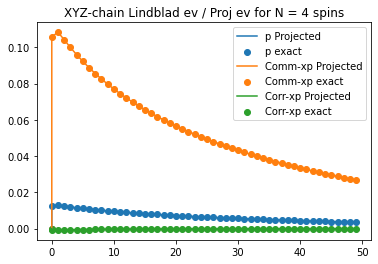

In [7]:
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.plot(results["ts"], results["averages"][:,2], label="Comm-xp Projected")
plt.scatter(results["ts"], results["averages"][:,2], label="Comm-xp exact")
plt.plot(results["ts"], results["averages"][:,3], label="Corr-xp Projected")
plt.scatter(results["ts"], results["averages"][:,3], label="Corr-xp exact")

plt.title("XYZ-chain Lindblad ev / Proj ev for N = 4 spins")
plt.legend()

sampling: 30
sampling: 30


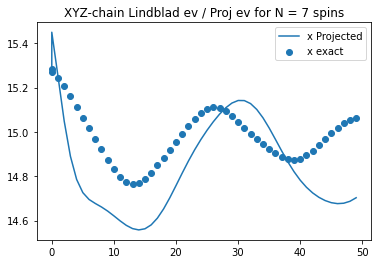

In [6]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(7, "XYZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(7, "XYZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.title("XYZ-chain Lindblad ev / Proj ev for N = 7 spins")
plt.legend()

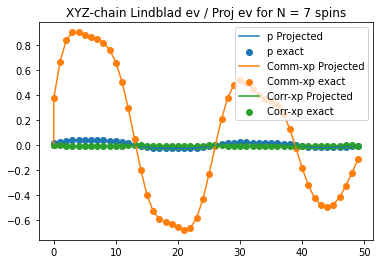

In [7]:
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.plot(results["ts"], results["averages"][:,2], label="Comm-xp Projected")
plt.scatter(results["ts"], results["averages"][:,2], label="Comm-xp exact")
plt.plot(results["ts"], results["averages"][:,3], label="Corr-xp Projected")
plt.scatter(results["ts"], results["averages"][:,3], label="Corr-xp exact")

plt.title("XYZ-chain Lindblad ev / Proj ev for N = 7 spins")
plt.legend()